# Customer Churning

In this notebook I go through the process of evaluating different Classification Models. I end up using `CatBoost`, as
it yielded the highest `recall` of all.

## Disclaimer

This notebook doesn't include an EDA nor any other type of analysis, given that I already submitted another
[notebook](https://www.kaggle.com/augusto1982/credit-card-customers-analysis) for that.

## Loading the data

In [156]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.inspection import permutation_importance
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import seaborn as sns

from sklearn.model_selection import GridSearchCV


from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import xgboost as xgb

In [157]:
df = pd.read_csv('../input/credit-card-customers/BankChurners.csv')
df = df.iloc[:, :-2]

# Setting the index
df.set_index('CLIENTNUM', inplace=True)

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [159]:
# Replacing 'Unknown' values.
categorical = ['Education_Level', 'Marital_Status', 'Income_Category']

encoders = {}

for cat in categorical:
    encoder = LabelEncoder()
    encoders[cat] = encoder
    values = df[cat]
    known_values = values[values != 'Unknown']
    df[cat] = pd.Series( encoder.fit_transform(known_values), index=known_values.index)

imp_cat = IterativeImputer(estimator=RandomForestClassifier(),
                           initial_strategy='most_frequent',
                           max_iter=10, random_state=0)


df[categorical] = imp_cat.fit_transform(df[categorical])

for cat in categorical:
    df[cat] = encoders[cat].inverse_transform(df[cat].astype(int))


In [160]:
def make_categorical(data: pd.DataFrame, column: str, categories: list, ordered: bool = False):
    data[column] = pd.Categorical(df[column],
                                       categories=categories,
                                       ordered=ordered)


df['Attrition_Flag'] = df['Attrition_Flag'].map({'Attrited Customer':1, 'Existing Customer':0})

make_categorical(df, 'Gender', ['F', 'M'])

make_categorical(df, 'Education_Level', ['Uneducated', 'High School', 'Graduate', 'College', 'Post-Graduate', 'Doctorate'], True)

make_categorical(df, 'Marital_Status', ['Married', 'Single', 'Divorced'])

make_categorical(df, 'Income_Category', ['Less than $40K', '$40K - $60K', '$60K - $80K', '$80K - $120K', '$120K +'], True)

make_categorical(df, 'Card_Category', ['Blue', 'Silver', 'Gold', 'Platinum'], True)

## Adding additional columns

In [161]:
# These columns I added while doing the EDA.

age_bins = [20, 40, 60, 80]
age_labels = ['20 - 40', '40 - 60', '60 - 80']
df['Age_Range'] = pd.cut(df['Customer_Age'], age_bins, labels=age_labels, ordered=True)

df['No_Revolving_Bal'] = df['Total_Revolving_Bal'] == 0

df['New_Customer'] = df['Months_on_book'] <= 24

df['Optimal_Utilization'] = df['Avg_Utilization_Ratio'] <= 0.3

# The next two columns I added after doing some Feature Selection analysis (more on that below).

df['Avg_Transaction'] = df['Total_Trans_Amt'] / df['Total_Trans_Ct']

def get_avg_q4_q1(row):
    if row['Total_Ct_Chng_Q4_Q1'] == 0:
        return 0
    return row['Total_Amt_Chng_Q4_Q1'] / row['Total_Ct_Chng_Q4_Q1']


df['Avg_Q4_Q1'] = df.apply(get_avg_q4_q1, axis=1)

## Encoding the categorical variables

In [162]:
label_encoding_columns = ['Education_Level', 'Marital_Status']

dummy_encoding_columns = ['Gender', 'Income_Category', 'Card_Category', 'Age_Range']

df[label_encoding_columns]= df[label_encoding_columns].apply(LabelEncoder().fit_transform)
df = pd.get_dummies(df, columns=dummy_encoding_columns, prefix=dummy_encoding_columns, drop_first=True)

## Splitting the target and independent variables

In [163]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

## Feature Selection

Here I don't use Feature Selection for selecting a subset of relevant features, as that didn't improve the score of the model.
Instead, I use it to determine which of the whole group turn out to be more relevant and see if there's any other column
I create to reinforce the model.

The process determined these are the most relevant:
```
[
    'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon',
    'Total_Revolving_Bal', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct',
    'Total_Ct_Chng_Q4_Q1', 'No_Revolving_Bal'
]
```

As we can see we have the columns regarding Q4/Q1, and the two for the total of transactions. Therefore, I decided
to create two additional columns, as I previously mentioned (`Avg_Transaction` and `Avg_Q4_Q1`).


In [164]:
# forest = ExtraTreesClassifier(n_estimators=250)
# forest.fit(X, y)
#
# feat_importances = pd.Series(forest.feature_importances_, index=X.columns).sort_values(ascending=False)
#
# sel = SelectFromModel(forest)
# sel.fit(X, y)
# selected_feat= X.columns[sel.get_support()]
#
# df_sel = df[selected_feat]

## Scaling the data

In [165]:
X = RobustScaler().fit_transform(X)

## Split into train and test sets

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)


## Evaluate different models with K-Fold

In [167]:
base_models = [
    ("LR_model", LogisticRegression(random_state=42,n_jobs=-1)),
    ("KNN_model", KNeighborsClassifier(n_jobs=-1)),
    ("SVM_model", SVC(random_state=42, kernel = 'rbf')),
    ("DT_model", DecisionTreeClassifier(random_state=42)),
    ("RF_model", RandomForestClassifier(random_state=42,n_jobs=-1)),
    ("XGB_model", XGBClassifier(random_state=42, n_jobs=-1, scale_pos_weight=5)),
    ("CXGB_model", CatBoostClassifier(random_state=42, auto_class_weights='Balanced'))
]


split = KFold(n_splits=4, shuffle=True, random_state=42)

# Preprocessing, fitting, making predictions and scoring for every model:
for name, model in base_models:

    # get cross validation score for each model:
    cv_results = cross_val_score(model,
                                 X, y,
                                 cv=split,
                                 scoring="recall",
                                 n_jobs=-1)
    # output:
    min_score = round(min(cv_results), 4)
    max_score = round(max(cv_results), 4)
    mean_score = round(np.mean(cv_results), 4)
    std_dev = round(np.std(cv_results), 4)
    print(f"{name} cross validation recall score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}")

LR_model cross validation recall score: 0.6263 +/- 0.0275 (std) min: 0.596, max: 0.6708
KNN_model cross validation recall score: 0.6068 +/- 0.0215 (std) min: 0.5895, max: 0.6436
SVM_model cross validation recall score: 0.7056 +/- 0.0222 (std) min: 0.6843, max: 0.7426
DT_model cross validation recall score: 0.8097 +/- 0.0282 (std) min: 0.7709, max: 0.8465
RF_model cross validation recall score: 0.8334 +/- 0.0115 (std) min: 0.8232, max: 0.8515
XGB_model cross validation recall score: 0.9169 +/- 0.0154 (std) min: 0.8995, max: 0.9356
CXGB_model cross validation recall score: 0.9447 +/- 0.012 (std) min: 0.9314, max: 0.9629


As we can see, `CatBoost` seems to be the best option.

## Search for optimal hyperparameters

I commented the code below, given that it takes hours to run. Its execution produced the following combination of parameters:

```
{
    'border_count': 100,
    'depth': 6,
    'iterations': 250,
    'l2_leaf_reg': 100,
    'learning_rate': 0.1
}
```

However, I ran this before adding the last two columns, so I tweak them manually some more afterwards.

In [168]:
# grid_params = {
#     'depth':[4, 5, 6, 7, 8 ,9, 10],
#     'iterations':[250, 500, 1000],
#     'learning_rate':[0.001, 0.1, 0.2, 0.3],
#     'l2_leaf_reg':[3, 5, 10, 100],
#     'border_count':[10, 20, 50, 100],
# }
#
# gd_sr = GridSearchCV(estimator=CatBoostClassifier(random_state=42, auto_class_weights='Balanced'),
#                      param_grid=grid_params,
#                      scoring='recall',
#                      cv=5,
#                      n_jobs=-1)
#
# gd_sr.fit(X_train, y_train)
#
# best_parameters = gd_sr.best_params_
# print(best_parameters)

## Construction and execution of the optimal? model

In [169]:
best_classifier = CatBoostClassifier(
    random_state=42,
    border_count=100,
    depth=6,
    iterations=140,
    l2_leaf_reg=100,
    learning_rate=0.1,
    auto_class_weights='Balanced',
    verbose=False
)

best_classifier.fit(X_train, y_train)
y_pred = best_classifier.predict(X_test)

## Confusion Matrix

recall: 0.9405737704918032


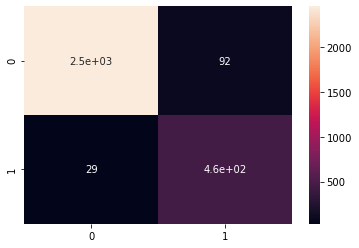

In [170]:
cm = confusion_matrix(y_test, y_pred)
recall = recall_score(y_test, y_pred)
# labels = ['Survived', 'No Survived']
ax = sns.heatmap(cm, annot=True)
print("recall: {}".format(recall))

## K-Fold and CatBoost

In [171]:

np.mean(
    cross_val_score(
        best_classifier,
        X,
        y,
        cv=split,
        scoring="recall",
        n_jobs=-1)
)



0.960138389330299